In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os, sys, h5py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import tensorflow as tf
import scipy

import sys
sys.path.append('../../..')
import mutagenesisfunctions as mf
import helper 
from deepomics import neuralnetwork as nn
from deepomics import utils, fit, visualize, saliency

#from Bio import AlignIO
import time as time
import pandas as pd

In [40]:


'''OPEN DATA'''

starttime = time.time()

exp = 'toyhp'  #for both the data folder and the params folder
exp_data = 'data_%s'%(exp)
t = 'med'

#Open data from h5py
filename = '%s_50k_%s.hdf5'%(exp, t)
data_path = os.path.join('../..', exp_data, filename)
with h5py.File(data_path, 'r') as dataset:
    X_data = np.array(dataset['X_data'])
    Y_data = np.array(dataset['Y_data'])

numdata, seqlen, dims = X_data.shape
X_data = np.expand_dims(X_data, axis=2)

# get validation and test set from training set
test_frac = 0.3
valid_frac = 0.1
N = numdata
split_1 = int(N*(1-valid_frac-test_frac))
split_2 = int(N*(1-test_frac))
shuffle = np.random.permutation(N)

#set up dictionaries
train = {'inputs': X_data[shuffle[:split_1]], 
       'targets': Y_data[shuffle[:split_1]]}
valid = {'inputs': X_data[shuffle[split_1:split_2]], 
       'targets': Y_data[shuffle[split_1:split_2]]}
test = {'inputs': X_data[shuffle[split_2:]], 
       'targets': Y_data[shuffle[split_2:]]}

print ('Data extraction and dict construction completed in: ' + mf.sectotime(time.time() - starttime))



Data extraction and dict construction completed in: 0.26s


In [41]:
'''SAVE PATHS AND PARAMETERS'''
params_results = '../../results'

modelarch = 'resbind'
trial = t
modelsavename = '%s_%s'%(modelarch, trial)



'''BUILD NEURAL NETWORK'''

def cnn_model(input_shape, output_shape):

    # create model
    layer1 = {'layer': 'input', #41
          'input_shape': input_shape
          }
    layer2 = {'layer': 'conv1d',
          'num_filters': 96,
          'filter_size': input_shape[1]-29,
          'norm': 'batch',
          'activation': 'relu',
          'dropout': 0.3,
          'padding': 'VALID',
          }
    layer3 = {'layer': 'conv1d_residual',
          'filter_size': 5,
          'function': 'relu',
          'dropout_block': 0.1,
          'dropout': 0.3,
          'mean_pool': 10,
          }

    layer4 = {'layer': 'dense',        # input, conv1d, dense, conv1d_residual, dense_residual, conv1d_transpose,
                                  # concat, embedding, variational_normal, variational_softmax, + more
        'num_units': 196,
        'norm': 'batch',          # if removed, automatically adds bias instead
        'activation': 'relu',     # or leaky_relu, prelu, sigmoid, tanh, etc
        'dropout': 0.5,           # if removed, default is no dropout
           }


    layer5 = {'layer': 'dense',
          'num_units': output_shape[1],
          'activation': 'sigmoid'
          }

    model_layers = [layer1, layer2, layer3, layer4, layer5]

    # optimization parameters
    optimization = {"objective": "binary",
                "optimizer": "adam",
                "learning_rate": 0.0003,
                "l2": 1e-5,
                #"label_smoothing": 0.05,
                #"l1": 1e-6,
                }
    return model_layers, optimization

tf.reset_default_graph()

# get shapes of inputs and targets
input_shape = list(train['inputs'].shape)
input_shape[0] = None
output_shape = train['targets'].shape

# load model parameters
model_layers, optimization = cnn_model(input_shape, output_shape)

# build neural network class
nnmodel = nn.NeuralNet(seed=247)
nnmodel.build_layers(model_layers, optimization)

# compile neural trainer
save_path = os.path.join(params_results, exp)
param_path = os.path.join(save_path, modelsavename)
nntrainer = nn.NeuralTrainer(nnmodel, save='best', file_path=param_path)

sess = utils.initialize_session()

In [42]:
sess = utils.initialize_session()
nntrainer.set_best_parameters(sess)

# test model
loss, mean_vals, std_vals = nntrainer.test_model(sess, test, name='test')

predictionsoutput = nntrainer.get_activations(sess, test, layer='output')
plot_index = np.argsort(predictionsoutput[:,0])[::-1]

loading model from:  ../../results/toyhp/resbind_med_best.ckpt
INFO:tensorflow:Restoring parameters from ../../results/toyhp/resbind_med_best.ckpt
  test  loss:		0.04727
  test  accuracy:	0.99197+/-0.00000
  test  auc-roc:	0.99978+/-0.00000
  test  auc-pr:		0.99972+/-0.00000


In [43]:
num_summary = 500

arrayspath = 'Arrays/toyhp_resbind_o_1k.npy'
Xdict = test['inputs'][plot_index[:num_summary]]

mean_mut2 = mf.som_average_ungapped(Xdict, ungapped_index=np.arange(seqlen), savepath=arrayspath, nntrainer=nntrainer, 
                                sess=sess, progress='short', save=True, layer='output', 
                               normalize='False')

0
Epoch duration =49.93s
Cumulative duration =0.5s

100
Epoch duration =40.87s
Cumulative duration =41.18s

200
Epoch duration =40.57s
Cumulative duration =1min 21.89s

300
Epoch duration =40.45s
Cumulative duration =2min 2.5999999999999943s

400
Epoch duration =40.85s
Cumulative duration =2min 43.349999999999994s

----------------Summing complete----------------
Saving scores to Arrays/toyhp_resbind_o_1k.npy


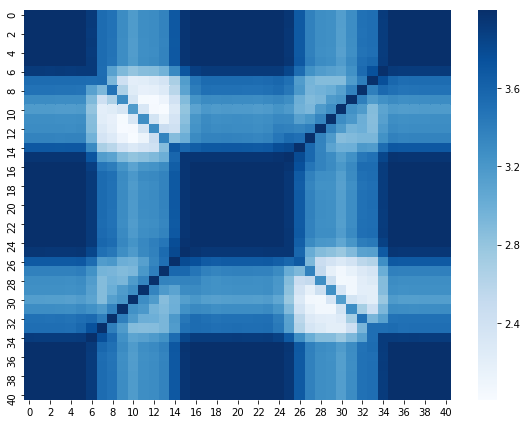

In [73]:
#Load the saved data
num_summary = 2000

arrayspath = 'Arrays/toyhp_resbind_o_1k.npy'
mean_mut2 = np.load(arrayspath)

#Reshape into a holistic tensor organizing the mutations into 4*4
meanhol_mut2 = mean_mut2.reshape(seqlen,seqlen,4,4)

#Normalize
normalize = False
if normalize:
    meanhol_mut2 = mf.normalize_mut_hol(meanhol_mut2, nntrainer=0, sess=0, normfactor=0)

#Let's try something weird
bpfilter = np.ones((4,4))*0
for i,j in zip(range(4), range(4)):
    bpfilter[i, -(j+1)] = +1.

nofilter = np.ones((4,4))
;
C = (meanhol_mut2*bpfilter)
C = np.sum((C).reshape(seqlen,seqlen,dims*dims), axis=2)
#C = C - np.mean(C)
#C = C/np.sum(C)

plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sb.heatmap(C,vmin=None, cmap='Blues', linewidth=0.0)
plt.show()


In [74]:
def APC_hol(hol):
    cor_hol = np.zeros_like(hol)
    wid = len(hol)
    
    w_hat = np.mean(hol)
    for r in range(wid):
        for c in range(wid):
            cor_hol[r,c] = hol[r,c] - np.mean(hol[r,:])*np.mean(hol[:,c])/w_hat
    
    return (cor_hol)

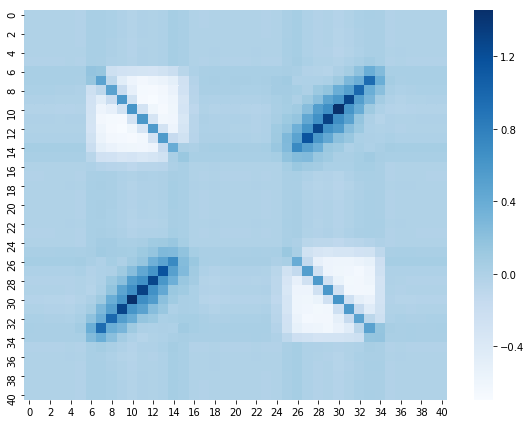

In [75]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sb.heatmap(APC_hol(C), cmap='Blues', linewidth=0.0)
plt.show()

In [33]:
def plotKLDscores_toy(meanhol_mut2, cmap='RdPu'):
    K = bp.KLD_hol(meanhol_mut2, bp.bp_probmx())

    plt.figure(figsize=(15,6))
    plt.subplot(1,2,1)
    sb.heatmap(K, cmap=cmap, linewidth=0.0)
    plt.title('Base Pair score for the ungapped consensus regions given by infernal')
    plt.xlabel('Ungapped nucleotides: pos 1')
    plt.ylabel('Ungapped nucleotides: pos 2')
    plt.show()
    return (K)

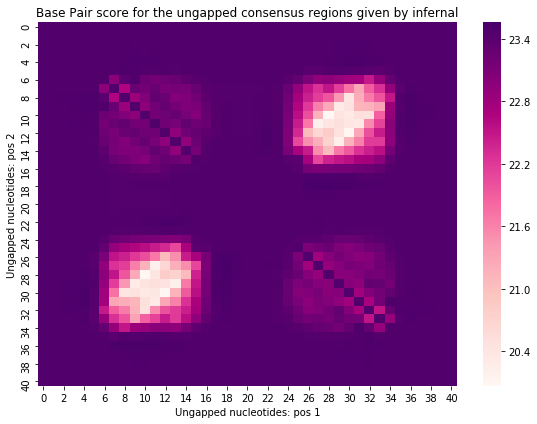

In [34]:
import bpdev as bp

bp.plotKLDscores_toy(meanhol_mut2)

In [55]:
#pull out the base pairs from the holistic scores array
ugSS = '.'*6 +'('*11 + '.'*7 +  ')'*11 + '.'*6


numbp = 22
dims = 4

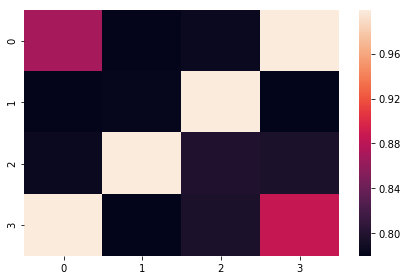

In [56]:
abh = bp.avgholbp(ugSS, numbp, dims, meanhol_mut2)

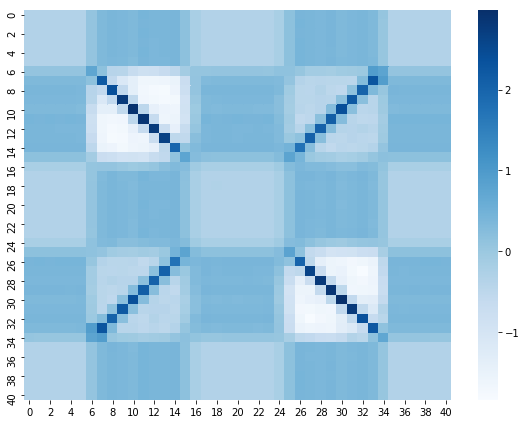

In [57]:
C = (meanhol_mut2*abh)
C = np.sum((C).reshape(seqlen,seqlen,dims*dims), axis=2)
#C = C - np.mean(C)
#C = C/np.max(C)

plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sb.heatmap(APC_hol(C),vmin=None, cmap='Blues', linewidth=0.0)
plt.show()

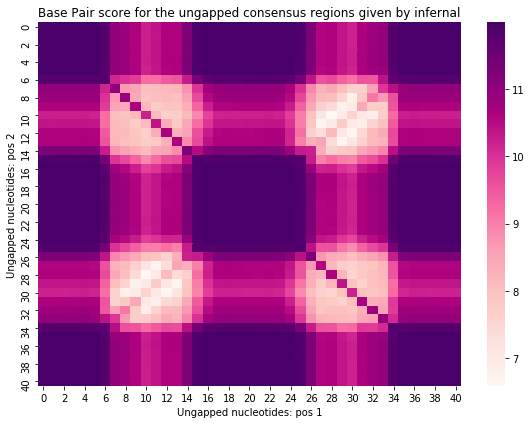

In [37]:
def stupid(hol_mut, ref):
    stu_scores = np.zeros((hol_mut.shape[0], hol_mut.shape[0]))
    for one in range(hol_mut.shape[0]):
        for two in range(hol_mut.shape[0]):
            stu_scores[one, two] = np.sum(np.abs(hol_mut[one, two] -  ref))
    return (stu_scores)

T = stupid(meanhol_mut2, bpfilter)


plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sb.heatmap(T, cmap='RdPu', linewidth=0.0)
plt.title('Base Pair score for the ungapped consensus regions given by infernal')
plt.xlabel('Ungapped nucleotides: pos 1')
plt.ylabel('Ungapped nucleotides: pos 2')
plt.show()